In [17]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
# from torchsummary import summary


# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Sat Mar  4 15:39:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    31W /  70W |   1142MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------

In [18]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transforms_cifar10 = transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

cifar10_data_train = datasets.CIFAR10('./data/cifar10/', train=True, download=True, transform=transforms_cifar10)
cifar10_data_test = datasets.CIFAR10('../data/cifar10/', train=False, download=True, transform=transforms_cifar10)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
classes_cifar10 = np.array(list(cifar10_data_train.class_to_idx.values()))
classes_test_cifar10 = np.array(list(cifar10_data_test.class_to_idx.values()))
num_classes_cifar10 = len(classes_test_cifar10)
print("Classes: {} \tType: {}".format(classes_cifar10, type(classes_cifar10)))
print("Classes Test: {} \tType: {}".format(classes_test_cifar10, type(classes_cifar10)))

Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [20]:
print("Image Shape CIFAR10: {}".format(cifar10_data_train.data[0].shape))

Image Shape CIFAR10: (32, 32, 3)


## Partitioning the Data (IID and non-IID)

In [21]:
def iid_partition(dataset, clients):
    
    num_items_per_client = int(len(dataset)/clients)
    client_dict = {}
    image_idxs = [i for i in range(len(dataset))]

    for i in range(clients):
        client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
        image_idxs = list(set(image_idxs) - client_dict[i])

    return client_dict

In [22]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client, dtype=None):
    
    shard_idxs = [i for i in range(total_shards)]
    client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
    idxs = np.arange(len(dataset))
    # print(len(idxs))
    if dtype == 'CIFAR10':
        data_labels = np.array(dataset.targets)
    elif dtype == 'MNIST':
        data_labels = dataset.targets.numpy()
    else:
        raise NotImplementedError

    # sort the labels
    label_idxs = np.vstack((idxs, data_labels))
    label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
    idxs = label_idxs[0,:]

    # divide the data into total_shards of size shards_size
    # assign num_shards_per_client to each client
    for i in range(clients):
        rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
        shard_idxs = list(set(shard_idxs) - rand_set)

        for rand in rand_set:
            client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
    return client_dict

In [23]:
class CustomDataset(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

## Models

In [24]:
class LeNet(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(400, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        out = self.sigmoid(x)
        return out

## Federated Averaging

### Local Training (Client Update)

In [25]:
class ClientUpdate(object):
    def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
        self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)

        self.learning_rate = learning_rate
        self.epochs = epochs

    def train(self, model):

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
        # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

        e_loss = []
        for epoch in range(1, self.epochs+1):

            train_loss = 0.0

            model.train()
            for data, labels in self.train_loader:

                if torch.cuda.is_available():
                    data, labels = data.cuda(), labels.cuda()

                # clear the gradients
                optimizer.zero_grad()
                # make a forward pass
                output = model(data)
                # calculate the loss
                loss = criterion(output, labels)
                # do a backwards pass
                loss.backward()
                # perform a single optimization step
                optimizer.step()
                # update training loss
                train_loss += loss.item()*data.size(0)

              # average losses
            train_loss = train_loss/len(self.train_loader.dataset)
            e_loss.append(train_loss)

        total_loss = sum(e_loss)/len(e_loss)

        return model.state_dict(), total_loss

### Server side training

In [26]:
def training(model, rounds, batch_size, lr, ds, data_dict, C, K, E, plt_title=None, plt_color=None):
    
    # global model weights
    global_weights = model.state_dict()

    # training loss
    train_loss = []
  
    # measure time
    start = time.time()

    for curr_round in tqdm(range(1, rounds+1)):
        w, local_loss = [], []

        m = max(int(C*K), 1)

        S_t = np.random.choice(range(K), m, replace=False)
        for k in S_t:
            local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=data_dict[k])
            weights, loss = local_update.train(model=copy.deepcopy(model))

            w.append(copy.deepcopy(weights))
            local_loss.append(copy.deepcopy(loss))

        # updating the global weights
        weights_avg = copy.deepcopy(w[0])
        for k in weights_avg.keys():
            for i in range(1, len(w)):
                weights_avg[k] += w[i][k]

            weights_avg[k] = torch.div(weights_avg[k], len(w))

        global_weights = weights_avg

        # move the updated weights to our model state dict
        model.load_state_dict(global_weights)

        # loss
        loss_avg = sum(local_loss) / len(local_loss)
        
#         print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
        train_loss.append(loss_avg)

    end = time.time()
#     fig, ax = plt.subplots()
#     x_axis = np.arange(1, rounds+1)
#     y_axis = np.array(train_loss)
#     ax.plot(x_axis, y_axis, 'tab:'+plt_color)

#     ax.set(xlabel='Number of Rounds', ylabel='Train Loss', title=plt_title)
#     ax.grid()
#     fig.savefig(plt_title+'.jpg', format='jpg')
    print("Training Done!")
    print("Total time taken to Train: {}".format(end-start))
  
    return model, train_loss

## Testing Loop

In [27]:
def testing(model, dataset, bs, criterion, num_classes, classes):
  #test loss 
    test_loss = 0.0
    correct_class = list(0. for i in range(num_classes))
    total_class = list(0. for i in range(num_classes))

    test_loader = DataLoader(dataset, batch_size=bs)
    l = len(test_loader)
    model.eval()
    for data, labels in test_loader:

        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        output = model(data)
        loss = criterion(output, labels)
        test_loss += loss.item()*data.size(0)

        _, pred = torch.max(output, 1)

        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

        #test accuracy for each object class
        for i in range(num_classes):
            label = labels.data[i]
            correct_class[label] += correct[i].item()
            total_class[label] += 1
    
  # avg test loss
    test_loss = test_loss/len(test_loader.dataset)
    print("Test Loss: {:.6f}\n".format(test_loss))

  # print test accuracy
    for i in range(10):
        if total_class[i]>0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
            (classes[i], 100 * correct_class[i] / total_class[i],
            np.sum(correct_class[i]), np.sum(total_class[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
        100. * np.sum(correct_class) / np.sum(total_class),
        np.sum(correct_class), np.sum(total_class)))

## CIFAR10

In [28]:
rounds = 200
C = 0.1
K = 100
E = 5
lr=0.01

### Train (IID)

In [29]:
iid_dict = iid_partition(cifar10_data_train, 100)
model_b_10 = LeNet()
model_b_30 = LeNet()
model_b_60 = LeNet()

if torch.cuda.is_available():
    model_b_10.cuda()
    model_b_30.cuda()
    model_b_60.cuda()

batch_size = 10
print("Training start, B = {}".format(batch_size))
cifar10_iid_b_10, train_loss_iid_10 = training(model_b_10, rounds, batch_size, lr, cifar10_data_train, iid_dict, C, K, E)
print("----------------------")
print()

batch_size = 30
print("Training start, B = {}".format(batch_size))
cifar10_iid_b_30, train_loss_iid_30 = training(model_b_30, rounds, batch_size, lr, cifar10_data_train, iid_dict, C, K, E)
print("----------------------")
print()

batch_size = 60
print("Training start, B = {}".format(batch_size))
cifar10_iid_b_60, train_loss_iid_60 = training(model_b_60, rounds, batch_size, lr, cifar10_data_train, iid_dict, C, K, E)
print("----------------------")
print()

Training start, B = 10


100%|██████████| 200/200 [37:11<00:00, 11.16s/it]


Training Done!
Total time taken to Train: 2231.9440474510193
----------------------

Training start, B = 30


100%|██████████| 200/200 [24:07<00:00,  7.24s/it]


Training Done!
Total time taken to Train: 1447.3924689292908
----------------------

Training start, B = 60


100%|██████████| 200/200 [22:23<00:00,  6.72s/it]

Training Done!
Total time taken to Train: 1343.3647556304932
----------------------



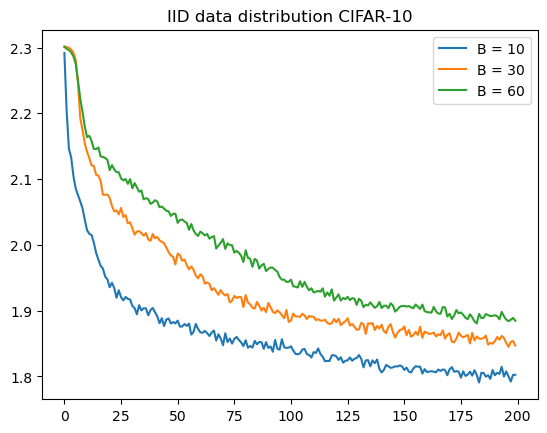

In [30]:
x = np.arange(rounds)
plt.plot(x, train_loss_iid_10, label="B = 10")
plt.plot(x, train_loss_iid_30, label="B = 30")
plt.plot(x, train_loss_iid_60, label="B = 60")
plt.title("IID data distribution CIFAR-10")
plt.legend()
plt.show()

### Test (IID)

In [31]:
criterion = nn.CrossEntropyLoss()

batch_size = 10
print("Testing for, B = {}".format(batch_size))
testing(cifar10_iid_b_10, cifar10_data_test, 128, criterion, num_classes_cifar10, classes_test_cifar10)
print("----------------------")
print()

batch_size = 30
print("Testing for, B = {}".format(batch_size))
testing(cifar10_iid_b_30, cifar10_data_test, 128, criterion, num_classes_cifar10, classes_test_cifar10)
print("----------------------")
print()

batch_size = 60
print("Testing for, B = {}".format(batch_size))
testing(cifar10_iid_b_60, cifar10_data_test, 128, criterion, num_classes_cifar10, classes_test_cifar10)
print("----------------------")
print()

Testing for, B = 10
Test Loss: 1.866107

Test Accuracy of     0: 56% (41/72)
Test Accuracy of     1: 69% (54/78)
Test Accuracy of     2: 34% (30/87)
Test Accuracy of     3: 30% (24/80)
Test Accuracy of     4: 38% (28/72)
Test Accuracy of     5: 38% (28/73)
Test Accuracy of     6: 61% (55/89)
Test Accuracy of     7: 64% (50/78)
Test Accuracy of     8: 62% (54/86)
Test Accuracy of     9: 42% (32/75)

Final Test  Accuracy: 50.127 (396.0/790.0)
----------------------

Testing for, B = 30
Test Loss: 1.906369

Test Accuracy of     0: 44% (32/72)
Test Accuracy of     1: 55% (43/78)
Test Accuracy of     2: 22% (20/87)
Test Accuracy of     3: 36% (29/80)
Test Accuracy of     4: 34% (25/72)
Test Accuracy of     5: 30% (22/73)
Test Accuracy of     6: 59% (53/89)
Test Accuracy of     7: 58% (46/78)
Test Accuracy of     8: 52% (45/86)
Test Accuracy of     9: 42% (32/75)

Final Test  Accuracy: 43.924 (347.0/790.0)
----------------------

Testing for, B = 60
Test Loss: 1.919047

Test Accuracy of     

### Train (Non IID)

In [33]:
non_iid_dict = non_iid_partition(cifar10_data_train, 100, 200, 250, 2, 'CIFAR10')
model_non_b_10 = LeNet()
model_non_b_30 = LeNet()
model_non_b_60 = LeNet()

if torch.cuda.is_available():
    model_non_b_10.cuda()
    model_non_b_30.cuda()
    model_non_b_60.cuda()

batch_size = 10
print("Training start, B = {}".format(batch_size))
cifar10_non_iid_b_10, train_loss_10 = training(model_non_b_10, rounds, batch_size, lr, cifar10_data_train, non_iid_dict, C, K, E)
print("----------------------")
print()

Training start, B = 10


100%|██████████| 200/200 [36:55<00:00, 11.08s/it]

Training Done!
Total time taken to Train: 2215.051540374756
----------------------



In [34]:
batch_size = 30
print("Training start, B = {}".format(batch_size))
cifar10_non_iid_b_30, train_loss_30 = training(model_non_b_30, rounds, batch_size, lr, cifar10_data_train, non_iid_dict, C, K, E)
print("----------------------")
print()

Training start, B = 30


100%|██████████| 200/200 [23:50<00:00,  7.15s/it]

Training Done!
Total time taken to Train: 1430.7396264076233
----------------------



In [35]:
batch_size = 60
print("Training start, B = {}".format(batch_size))
cifar10_non_iid_b_60, train_loss_60 = training(model_non_b_60, rounds, batch_size, lr, cifar10_data_train, non_iid_dict, C, K, E)
print("----------------------")
print()

Training start, B = 60


100%|██████████| 200/200 [22:02<00:00,  6.61s/it]

Training Done!
Total time taken to Train: 1322.8631165027618
----------------------



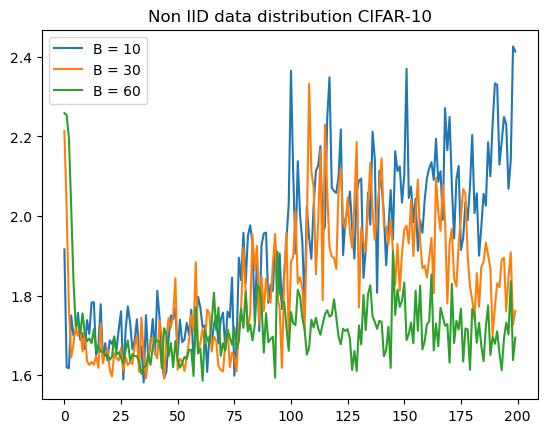

In [36]:
x = np.arange(rounds)
plt.plot(x, train_loss_10, label="B = 10")
plt.plot(x, train_loss_30, label="B = 30")
plt.plot(x, train_loss_60, label="B = 60")
plt.title("Non IID data distribution CIFAR-10")
plt.legend()
plt.show()

### Test (Non IID)

In [38]:
criterion = nn.CrossEntropyLoss()

batch_size = 10
print("Testing for, B = {}".format(batch_size))
testing(cifar10_non_iid_b_10, cifar10_data_test, 128, criterion, num_classes_cifar10, classes_test_cifar10)
print("----------------------")
print()

batch_size = 30
print("Testing for, B = {}".format(batch_size))
testing(cifar10_non_iid_b_30, cifar10_data_test, 128, criterion, num_classes_cifar10, classes_test_cifar10)
print("----------------------")
print()

batch_size = 60
print("Testing for, B = {}".format(batch_size))
testing(cifar10_non_iid_b_60, cifar10_data_test, 128, criterion, num_classes_cifar10, classes_test_cifar10)
print("----------------------")
print()

Testing for, B = 10
Test Loss: 2.415014

Test Accuracy of     0: 97% (70/72)
Test Accuracy of     1:  0% ( 0/78)
Test Accuracy of     2:  0% ( 0/87)
Test Accuracy of     3:  0% ( 0/80)
Test Accuracy of     4: 23% (17/72)
Test Accuracy of     5:  0% ( 0/73)
Test Accuracy of     6:  0% ( 0/89)
Test Accuracy of     7:  0% ( 0/78)
Test Accuracy of     8:  0% ( 0/86)
Test Accuracy of     9:  0% ( 0/75)

Final Test  Accuracy: 11.013 (87.0/790.0)
----------------------

Testing for, B = 30
Test Loss: 2.331110

Test Accuracy of     0:  5% ( 4/72)
Test Accuracy of     1:  0% ( 0/78)
Test Accuracy of     2:  0% ( 0/87)
Test Accuracy of     3:  0% ( 0/80)
Test Accuracy of     4: 100% (72/72)
Test Accuracy of     5:  0% ( 0/73)
Test Accuracy of     6:  0% ( 0/89)
Test Accuracy of     7:  0% ( 0/78)
Test Accuracy of     8:  2% ( 2/86)
Test Accuracy of     9:  0% ( 0/75)

Final Test  Accuracy: 9.873 (78.0/790.0)
----------------------

Testing for, B = 60
Test Loss: 2.239807

Test Accuracy of     0: